# **Importing Libraries**





In [1]:
import matplotlib.pyplot as plt
import pathlib, os, random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras


from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout , GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint

# **How many classes do we have?**

In [2]:
train_path="train/"
no_birds_classes = os.listdir(train_path)
len(no_birds_classes)

400

**Classes Names**

In [3]:
data_dir = pathlib.Path("train")
BirdClasses = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(BirdClasses)

['ABBOTTS BABBLER' 'ABBOTTS BOOBY' 'ABYSSINIAN GROUND HORNBILL'
 'AFRICAN CROWNED CRANE' 'AFRICAN EMERALD CUCKOO' 'AFRICAN FIREFINCH'
 'AFRICAN OYSTER CATCHER' 'ALBATROSS' 'ALBERTS TOWHEE'
 'ALEXANDRINE PARAKEET' 'ALPINE CHOUGH' 'ALTAMIRA YELLOWTHROAT'
 'AMERICAN AVOCET' 'AMERICAN BITTERN' 'AMERICAN COOT' 'AMERICAN GOLDFINCH'
 'AMERICAN KESTREL' 'AMERICAN PIPIT' 'AMERICAN REDSTART'
 'AMETHYST WOODSTAR' 'ANDEAN GOOSE' 'ANDEAN LAPWING' 'ANDEAN SISKIN'
 'ANHINGA' 'ANIANIAU' 'ANNAS HUMMINGBIRD' 'ANTBIRD' 'ANTILLEAN EUPHONIA'
 'APAPANE' 'APOSTLEBIRD' 'ARARIPE MANAKIN' 'ASHY THRUSHBIRD'
 'ASIAN CRESTED IBIS' 'AVADAVAT' 'AZURE JAY' 'AZURE TANAGER' 'AZURE TIT'
 'BAIKAL TEAL' 'BALD EAGLE' 'BALD IBIS' 'BALI STARLING' 'BALTIMORE ORIOLE'
 'BANANAQUIT' 'BAND TAILED GUAN' 'BANDED BROADBILL' 'BANDED PITA'
 'BANDED STILT' 'BAR-TAILED GODWIT' 'BARN OWL' 'BARN SWALLOW'
 'BARRED PUFFBIRD' 'BARROWS GOLDENEYE' 'BAY-BREASTED WARBLER'
 'BEARDED BARBET' 'BEARDED BELLBIRD' 'BEARDED REEDLING'
 'BELTED KINGFISHE

# **Visualizing Images**

In [4]:
def view_random_image(target_dir, target_class):
  
  # setting up the image directory
  target_folder = target_dir + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = plt.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  #print(f"Image shape: {img.shape}")
  
  return img

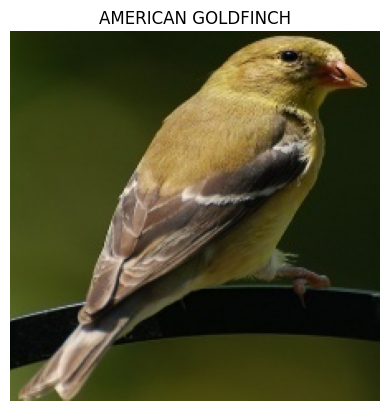

In [5]:
img = view_random_image(train_path,'AMERICAN GOLDFINCH')

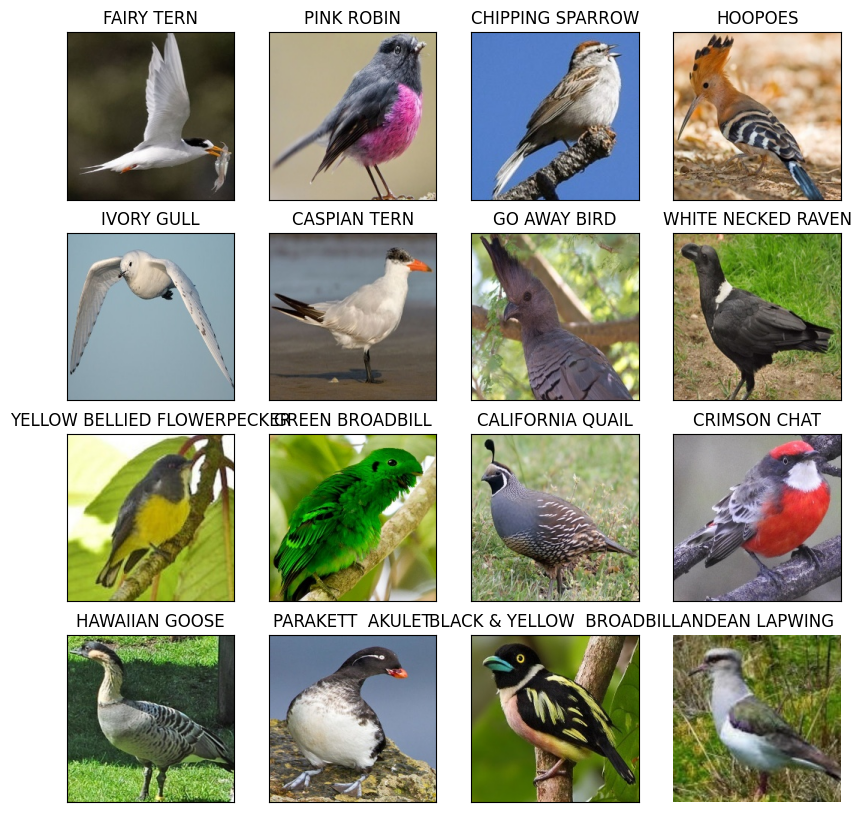

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

random_index = np.random.randint(0 , len(BirdClasses)-1 , 16)

for i, ax in enumerate(axes.flat):
    ax.imshow(view_random_image(train_path,BirdClasses[random_index[i]]))
    ax.set_title(BirdClasses[random_index[i]])

# **Data Preprocessing**

In [8]:
train_dir = "train/"
test_dir = "test/"
val_dir = "valid/"

In [9]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [10]:
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory( train_dir , target_size=(224,224) , batch_size=32 , class_mode = "categorical" ,shuffle=True )

val_data = val_gen.flow_from_directory( val_dir , target_size=(224,224) , batch_size=32 , class_mode = "categorical" , shuffle=True )

test_data = test_gen.flow_from_directory( test_dir , target_size=(224,224) , batch_size=32 , class_mode = "categorical" ,shuffle=False )


Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 1998 images belonging to 400 classes.


# **Preparing MobileNet Pretrained Model**

In [11]:
mobilenet = MobileNetV2( include_top=False , weights="imagenet" , input_shape=(224,224,3))

mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

# **Fine-Tuning MobileNet Model**

In [12]:
# Freezing all layers except the last 20 layers

mobilenet.trainable=True


for layer in mobilenet.layers[:-20]:
  layer.trainable=False

In [13]:
Model = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dense(400,activation='softmax')
])

Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [14]:
Model.compile( optimizer="adam", loss="categorical_crossentropy" , metrics=["accuracy"] )

In [15]:
# Create Callback Checkpoint

#checkpoint_path = "BirdsSpecies_Model_Checkpoint"
#checkpoint_callback = ModelCheckpoint(checkpoint_path,monitor="val_accuracy",save_best_only=True)

callbacks = [EarlyStopping(monitor='val_accuracy' , patience=5 , restore_best_weights=True)]

In [16]:
history = Model.fit(train_data,epochs=5 , batch_size=64 ,steps_per_epoch = len(train_data)
,callbacks=callbacks ,workers=10,use_multiprocessing=False, validation_data=val_data,validation_steps = len(val_data))

Epoch 1/5
1825/1825 [==============================] - 1164s 636ms/step - loss: 1.3197 - accuracy: 0.7031 - val_loss: 1.7528 - val_accuracy: 0.5595
Epoch 2/5
1825/1825 [==============================] - 1149s 630ms/step - loss: 0.4699 - accuracy: 0.8715 - val_loss: 0.7887 - val_accuracy: 0.7850
Epoch 3/5
1825/1825 [==============================] - 1149s 630ms/step - loss: 0.3325 - accuracy: 0.9037 - val_loss: 0.6412 - val_accuracy: 0.8410
Epoch 4/5
1825/1825 [==============================] - 1150s 630ms/step - loss: 0.2519 - accuracy: 0.9259 - val_loss: 0.6077 - val_accuracy: 0.8565
Epoch 5/5
1825/1825 [==============================] - 1149s 629ms/step - loss: 0.2059 - accuracy: 0.9377 - val_loss: 0.4278 - val_accuracy: 0.8995


# **Evaluating The Model**

In [17]:
results = Model.evaluate(test_data, verbose=0)


print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.34912
Test Accuracy: 90.04%


In [18]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()
  plt.show()
  plt.tight_layout()

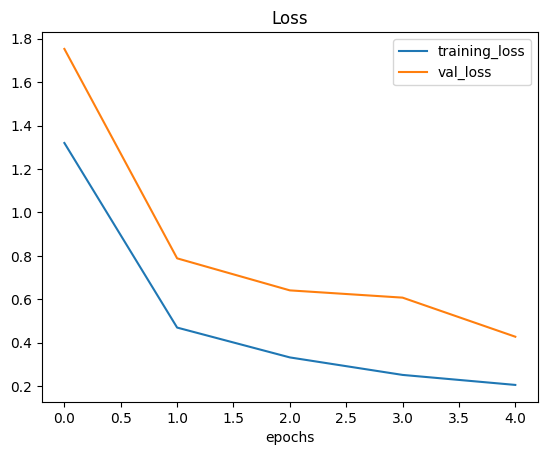

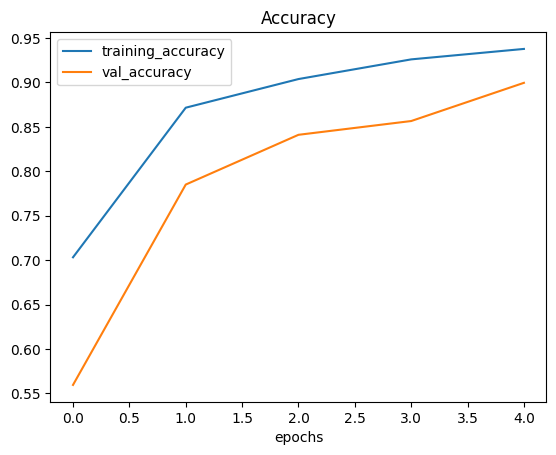

<Figure size 640x480 with 0 Axes>

In [19]:
plot_curves(history)

# **Predicting Test Set**

In [20]:
pred = Model.predict(test_data)
pred = np.argmax(pred,axis=1)

63/63 [==============================] - 33s 508ms/step


True Label: AMERICAN AVOCET
Predicted Label: AMERICAN AVOCET


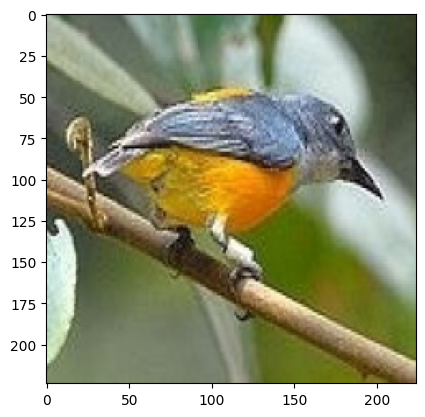

In [21]:
index =62

img , label = test_data[index]
label = test_data.labels[index]
print(f"True Label: {BirdClasses[label]}")
print(f"Predicted Label: {BirdClasses[pred[index]]}")  
plt.imshow(img[0])
plt.show()

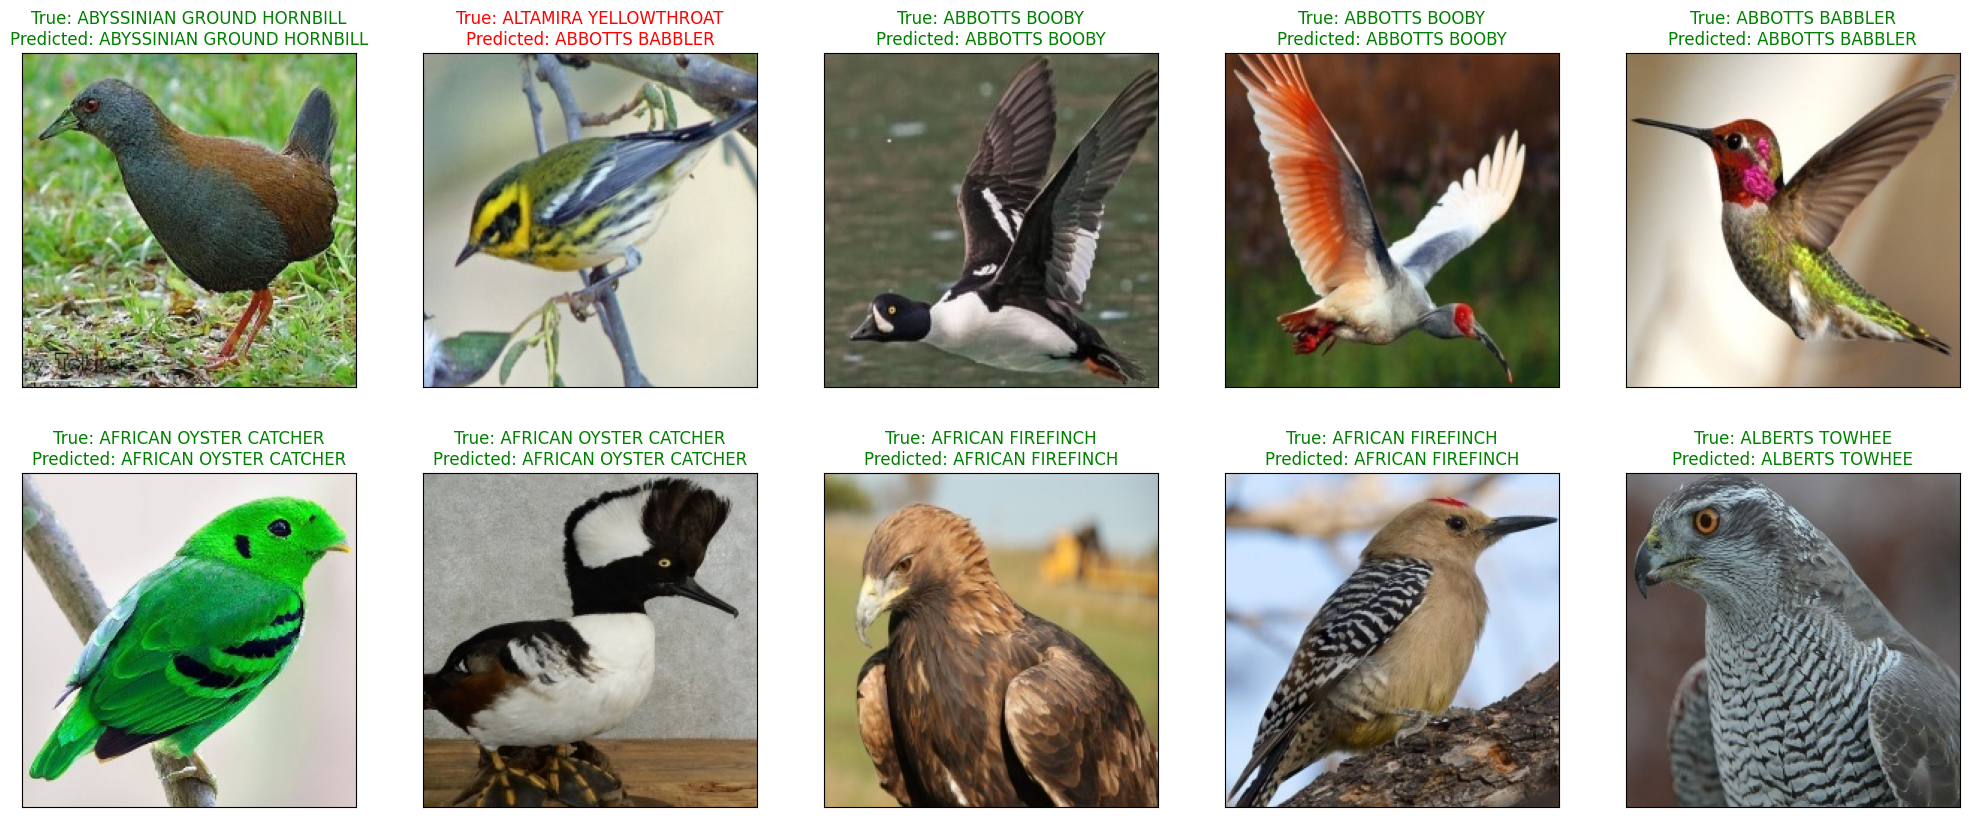

<Figure size 640x480 with 0 Axes>

In [23]:
# Display 10 random pictures from the dataset with their labels

random_index = np.random.randint(0, len(test_data) - 1, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    randImg , randLabel = test_data[random_index[i]]
    randLabel = test_data.labels[random_index[i]]
    ax.imshow(randImg[0])
    if BirdClasses[randLabel] == BirdClasses[pred[random_index[i]]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {BirdClasses[randLabel]}\nPredicted: {BirdClasses[pred[random_index[i]]]}", color=color)
plt.show()
plt.tight_layout()

# **Predicting Random Image**

In [24]:
def load_and_prep_image(filename, img_shape = 224):
  img = tf.io.read_file(filename) #read image
  img = tf.image.decode_image(img) # decode the image to a tensor
  img = tf.image.resize(img, size = [img_shape, img_shape]) # resize the image
  img = img/255. # rescale the image
  return img

In [25]:
def pred_and_plot(filename, class_names):

  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = Model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[pred.argmax()]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

**Predicting image from ABBOTTS BABBLER file**

1/1 [==============================] - 1s 800ms/step


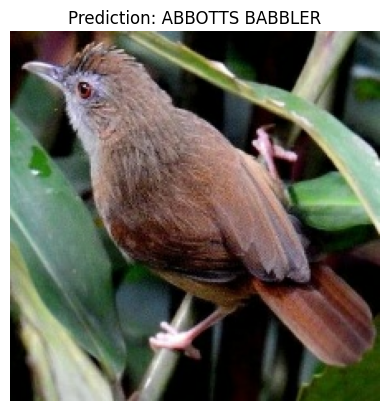

In [29]:
pred_and_plot("test/ABBOTTS BABBLER/1.jpg", BirdClasses)

Predicting image from AMERICAN AVOCET file

1/1 [==============================] - 0s 37ms/step


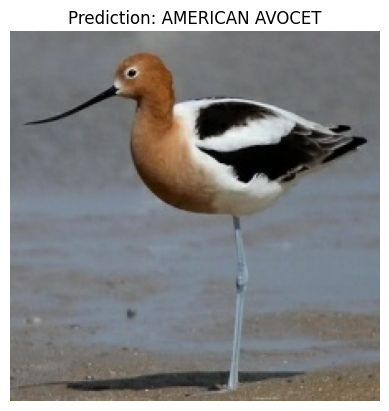

In [31]:
pred_and_plot("test/AMERICAN AVOCET/4.jpg", BirdClasses)

In [32]:
Model.save("BC.h5")